# Example Usage & Plotting

In [8]:
import numpy as np
import gseapy
from scipy.sparse import csr_matrix
from tqdm.contrib.concurrent import process_map
from functools import partial
from scipy.sparse.csgraph import shortest_path
import matplotlib.pyplot as plt
import seaborn as sns
import numba as nb
from sklearn.manifold import SpectralEmbedding
import networkx
import pandas as pd
import random
import networkx

from geneclusters.cluster_genes_new import evaluate_cut, plot_component, plot_edges, plot_nodes, plot_single_cluster, group, compute_groupped_matrix, get_scores, find_similar_clusters, get_representative_name_per_cluster, get_kernighan_lin_clusters, get_gene_pathway_matrix, get_full_matrix_from_bipartite

## Choose initiation

In [10]:
p = './examples/GO_Biological_Process_2023.npy'
mat = get_gene_pathway_matrix(p)
N = 1000

mmap_1 = './examples/GO_Biological_Process_2023_labels_30.npy'
mmap_2 = './examples/GO_Biological_Process_2023_losses_30.npy'

mode = 'r'

labels = np.lib.format.open_memmap(mmap_1, shape=(N, sum(mat.shape)), dtype=int, mode=mode)
losses = np.lib.format.open_memmap(mmap_2, shape=(1, N), dtype=int, mode=mode)

labeling = labels[np.argmin(losses[0])]
matrix = np.ascontiguousarray(mat.values.T)
pathway_names = mat.index
gene_names = mat.columns
frame = pd.DataFrame(labeling)
frame['description'] = np.concatenate([gene_names, pathway_names])
frame['is_gene'] = np.arange(frame.shape[0]) < matrix.shape[0]

In [11]:
frame.columns = ['cluster', 'description', 'is_gene']

In [12]:
frame.head()

,cluster,description,is_gene
0,544,A4GNT,True
1,632,AAK1,True
2,128,AARS1,True
3,189,AARS2,True
4,441,AASDHPPT,True


# Cluster merging

In [13]:
matrix = np.array(mat)
cols = np.array(frame[frame['is_gene']]['cluster'])
rows = np.array(frame[np.invert(frame['is_gene'])]['cluster'])

In [14]:
# merge clusters that fall within certain threshold
groupped_matrix, mapping = compute_groupped_matrix(matrix, cols, rows)
to_merge = find_similar_clusters(groupped_matrix)
inverse_mapping = {v: k for (k, v) in mapping.items()}
to_merge_remapped = {inverse_mapping[k]: inverse_mapping[v] for (k, v) in to_merge.items()}
update_mapping = np.vectorize(lambda x: to_merge_remapped.get(x, x))
new_cols = update_mapping(cols)
new_rows = update_mapping(rows)
groupped_matrix_new, mapping = compute_groupped_matrix(matrix, new_cols, new_rows)

KeyboardInterrupt: 

In [ ]:
frame['new_cluster'] = np.concatenate((new_cols, new_rows))

In [ ]:
# plot pre and post merge heatmaps
# inspect the pre-merge heatmap to see if any clusters need to be merged
# specify the threshold accordingly 

embedding = SpectralEmbedding(n_components=1, affinity='precomputed')
X_transformed_new = embedding.fit_transform(groupped_matrix_new)
X_transformed = embedding.fit_transform(groupped_matrix)

o = np.argsort(X_transformed.ravel())
plt.imshow((groupped_matrix[o][:,o]))
plt.title('Fraction of edges shared between clusters before merging')

plt.figure()
o = np.argsort(X_transformed_new.ravel())
plt.imshow((groupped_matrix_new[o][:,o]))
plt.title('Fraction of edges shared between clusters after merging')

print(X_transformed.shape[0])
print(X_transformed_new.shape[0])

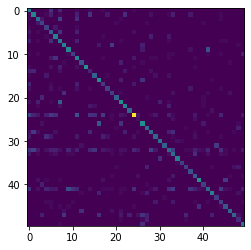

In [120]:
plt.imshow((groupped_matrix_new[o][:,o][:50,:50]))


In [121]:
frame.to_csv('./examples/GO_Biological_Process_2023_10_frame.csv')

# Assign represenative names

In [122]:
mat = get_gene_pathway_matrix(p)
colnames = np.array(mat.columns)
rownames = np.array(mat.index)

out = [get_representative_name_per_cluster(np.array(mat), colnames, rownames, frame, x) for x in np.unique(frame['new_cluster'])]
names = pd.DataFrame(out)
names.columns = ['cluster_ID', 'representative_pathway', 'fraction_internal_connections', 'N_internal_connections']


KeyboardInterrupt: 

In [111]:
names.to_csv('./examples/GO_Biological_Process_2023_10_names.csv')

In [112]:
names.head()

,cluster_ID,representative_pathway,fraction_internal_connections,N_internal_connections
0,C.0,Modulation By Symbiont Of Entry Into Host,0.619048,13.0
1,C.1,Folic Acid-Containing Compound Metabolic Process,1.000000,15.0
2,C.2,Leukocyte Tethering Or Rolling,0.588235,10.0
3,C.3,Formation Of Translation Preinitiation Complex,1.000000,8.0
4,C.4,Melanosome Transport,0.866667,13.0
